# CUNY DATA620 Final Project

## Kyle Gilde

## 12/15/2018


Gleaning information from customer reviews presents both challenges and opportunities for businesses. The challenges include bringing a formal, objective structure to unstructured, subjective natural language, while the results can yield valuable insights into customer attitudes towards the business.

For the final project, I will attempt to build a machine learning classification model that uses text of customer reviews to predict the review's numerical `star` rating. In effect, we will see if we can build a sentiment analysis classifier.

We will experiment with different natural language processing techniques to normalize the text and with different machine learning algorithms.

I took advantage of the [Yelp Open Dataset](https://www.yelp.com/dataset), which the company makes available for non-commercial use. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Exploratory Data Analysis

From the original 6 million reviews, I used [this Python script](https://github.com/kylegilde/D620-Web-Analytics/blob/master/Final%20Project/resize-data.py) to retain only the reviews that were written starting in 2016 and that at least 10 other Yelp customers deemed "useful". The latter condition should reduce the amount of random noise caused by poorly written reviews.  With these conditions, our data set was over 33K reviews.

In [20]:
raw_data = pd.read_csv('D:/documents/yelp_reviews.csv')[['stars', 'text', 'useful']]
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33255 entries, 0 to 33254
Data columns (total 3 columns):
stars     33255 non-null int64
text      33255 non-null object
useful    33255 non-null int64
dtypes: int64(2), object(1)
memory usage: 779.5+ KB


### The Response Variable

Our `star` response variable contains 5 imbalanced classes. The top rating of 5 is most common, closely followed by 4 and then 1. 2 stars is the least common class, followed by 3.

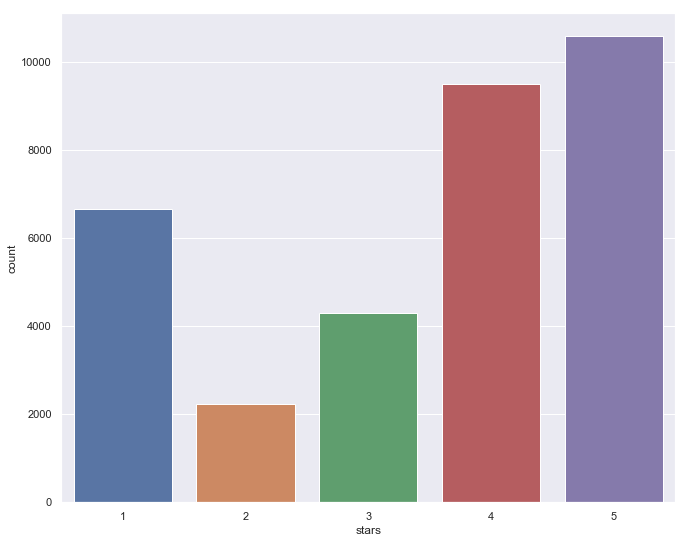

In [483]:
plt.figure(figsize=(11, 9))
sns.countplot(x='stars', data=raw_data)

### The Reviews

First, let's take a look at the most useful review from each star level. We observe the following:

- the reviews associated with bad ratings have more words that are completely capitalized and possibly more exclamation points.
- the negative reviews seem to have more words of negation, e.g. "no" & "not". Normally, these words would be removed from the text when we remove stopwords. However, for our purposes, we may want to consider leaving them in.
- we should see if the length of the review is positively correlated with the rating.


In [491]:
most_useful_review_idx = raw_data.groupby('stars')['useful'].idxmax()
most_useful_reviews = raw_data.loc[most_useful_review_idx, ['stars','text']].reset_index(drop=True)

pd.set_option('display.max_colwidth', 0)
# print(most_useful_reviews.to_csv(sep='\t', index=False))
print(most_useful_reviews.tolist(sep='\t', index=False))
# Source: https://stackoverflow.com/a/24646906/4463701

stars	text
1	"Was in Scottsdale visiting a friend and we stopped by here for a bite to eat. Possibly one of the worst dining experiences I have ever had. The owner (at least I think he was the owner) came out from the back of the kitchen and almost assaulted another patron for complaining that his meal was frozen solid in the middle. The couple quickly left the restaurant and we had a chuckle at this odd behavior but waited for our pizza. 

When our pizza finally came it was AWFUL! Growing up in NY I am a bit of a pizza snob and let me tell you, this barely passed as edible. It was cold, the cheese wasn't fully cooked and looked like it might have actually been a microwavable pizza. When I asked if they could heat it in the oven for longer they copped the biggest attitude and made us wait for 30 minutes. Absolutely terrible! Eventually we just got up and let after leaving a tip for the waitress.

I honestly thought I might have been on some type of reality TV show, that's how insanely 

Contrary to what we suspected, the 5-star level has the least number of words, and the 2-star rating has the most.

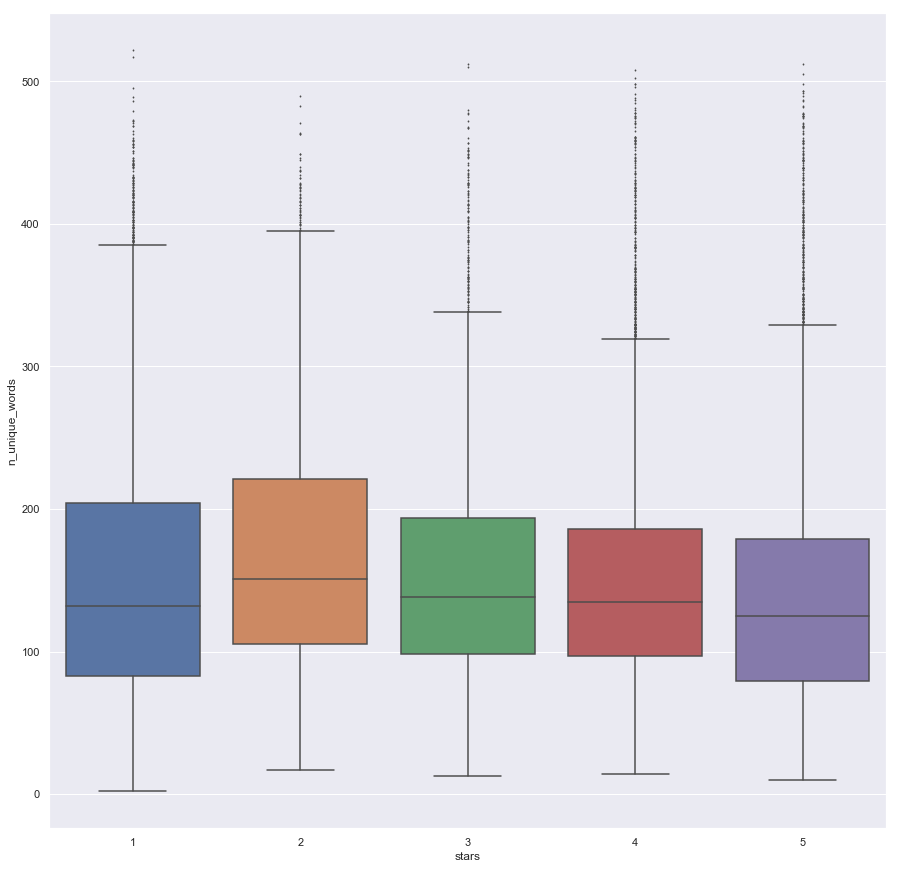

In [241]:
plt.figure(figsize=(15, 15))
# count words per review
raw_data['n_words'] = raw_data.text.str.lower().str.split().apply(len)
sns.boxplot(x='stars', y='n_words', fliersize=1, data=raw_data)

Next, let's use `nltk ` to normalize the our corpus and take a look at the most common words per star rating.
The normalization includes:

- converting the text to lowercase
- keeping only the tokens that begin with an alphabetic character
- keeping only the tokens with a length greater than 1
- removing the stopwords

In [335]:
stemmer = nltk.PorterStemmer()
revised_stopwords = [word for word in stopwords.words('english') if not word.endswith("n't") and word not in ['not', 'nor', 'no']] 

def stem_and_clean_text(doc):
    """
    Passed as the callable to Pandas.apply()
    Each token is stemmed and returned if it meets the conditions
    Sources: https://stackoverflow.com/a/36191362/4463701
    https://stackoverflow.com/a/51281480/4463701
    """
    stemmed_tokens = [stemmer.stem(token) for token in doc.split()\
                      if token.isalpha() # token contains only alphabetic characters
                      and len(token) > 1 # token is at least 2 characters long
                      and token not in revised_stopwords] # token is not among the revised stopwords
    return ' '.join(stemmed_tokens) 

raw_data['text_stemmed'] = raw_data.text.apply(stem_and_clean_text)

'dont'

In [346]:
token_counts = CountVectorizer(min_df=10,  
                               strip_accents='ascii',
                               ngram_range=(1, 3))

dtm_counts = token_counts.fit_transform(raw_data.text_stemmed)

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [435]:
correlated_n_grams

,n_gram,stars
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
5,2,1
6,2,2
7,2,3
8,2,4
9,2,5


In [474]:
top_n_tokens = 10
response_labels = np.sort(raw_data.stars.unique())
n_grams = np.arange(3) + 1


correlated_n_grams = pd.DataFrame(list(product(n_grams, response_labels)), columns=['n_gram', 'stars']) # , 'tokens', 'document_freq'

for response_label in response_labels:   
    features_chi2 = chi2(dtm_counts, raw_data.stars == response_label) # calc chi^2 for the class
    indices = np.argsort(features_chi2[0]) # get the sorted indices
    feature_names = np.array(token_counts.get_feature_names())[indices] # sort feature names ascendingly
    for n_gram in n_grams:
        the_tokens = [v for v in feature_names if len(v.split(' ')) == n_gram]         
        top_tokens = the_tokens[-top_n_tokens:]
        correlated_n_grams.loc[np.logical_and(correlated_n_grams.n_gram==n_gram, correlated_n_grams.stars==response_label), 'tokens'] = str(top_tokens)
        print("{}-star most correlated %d-grams:".format(response_label) % n_gram)
        print(". {}".format('\n. '.join(top_tokens)))


# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
# https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_selection/univariate_selection.py#L172


1-star most correlated 1-grams:
. would
. never
. no
. manag
. compani
. ask
. not
. said
. told
. call
1-star most correlated 2-grams:
. wast time
. could give
. phone call
. told would
. no one
. said would
. custom servic
. call back
. would not
. do not
1-star most correlated 3-grams:
. never go back
. would never recommend
. worst experi ever
. worst custom servic
. do not use
. could give zero
. give zero star
. would not recommend
. do not go
. if could give
2-star most correlated 1-grams:
. food
. wait
. bland
. mayb
. minut
. seem
. disappoint
. ask
. no
. not
2-star most correlated 2-grams:
. one plu
. low rate
. no one
. realli want
. not sure
. want like
. tast like
. give two
. not worth
. two star
2-star most correlated 3-grams:
. would not come
. on visit order
. wait anoth minut
. want give place
. yelp review overal
. no one care
. not go back
. realli want like
. get two star
. give two star
3-star most correlated 1-grams:
. averag
. food
. good
. tast
. pretti
. call

In [472]:
correlated_n_grams

,n_gram,stars,tokens
0,1,1,"['would', 'never', 'no', 'manag', 'compani', 'ask', 'not', 'said', 'told', 'call']"
1,1,2,"['food', 'wait', 'bland', 'mayb', 'minut', 'seem', 'disappoint', 'ask', 'no', 'not']"
2,1,3,"['averag', 'food', 'good', 'tast', 'pretti', 'call', 'the', 'order', 'decent', 'bit']"
3,1,4,"['compani', 'the', 'he', 'no', 'good', 'ask', 'said', 'not', 'told', 'call']"
4,1,5,"['best', 'ask', 'no', 'call', 'love', 'would', 'said', 'amaz', 'told', 'not']"
5,2,1,"['wast time', 'could give', 'phone call', 'told would', 'no one', 'said would', 'custom servic', 'call back', 'would not', 'do not']"
6,2,2,"['one plu', 'low rate', 'no one', 'realli want', 'not sure', 'want like', 'tast like', 'give two', 'not worth', 'two star']"
7,2,3,"['do not', 'noth realli', 'give three', 'flat white', 'highli recommend', 'the food', 'tast like', 'not sure', 'not bad', 'three star']"
8,2,4,"['pretti good', 'realli enjoy', 'no one', 'call back', 'realli like', 'the menu', 'would definit', 'custom servic', 'would not', 'do not']"
9,2,5,"['not worth', 'say enough', 'new favorit', 'absolut love', 'do not', 'no one', 'would not', 'one best', 'gluch group', 'highli recommend']"


In [ ]:

analyzer = CountVectorizer().build_analyzer() 

def stem_text(doc):
    """
    Passed as the callable for sklearn.feature_extraction.text classes
    Each token is stemmed and returned if it meets the conditions
    Source: https://stackoverflow.com/a/36191362/4463701
    """
    return (stemmer.stem(token) for token in analyzer(doc)\
            if token.isalpha() and len(token) > 1 and token not in revised_stopwords)

def text_processor_nltk(word):
    """"""
        return stemmer.stem(word).lower() if word.isalpha() and len(word) > 1 and word not in revised_stopwords
    
#text_cleaned = list(map(text_cleaner_v1, nl_text))
text_cleaned = list(map(, nl_text))

# plt.figure(figsize=(15, 15))
# sns.boxplot(x='useful', y='stars', orient='h', fliersize=1, data=raw_data)

# plt.figure(figsize=(15, 15))
# sns.boxplot(x='useful', y='stars', orient='h', fliersize=1, data=raw_data)

# sns.set(style="darkgrid")

# plt.figure(figsize=(9, 15))
# g = sns.FacetGrid(raw_data, col="stars", margin_titles=True)
# bins = np.linspace(0, np.max(raw_data['useful']), )
# g.map(plt.hist, "useful", color="steelblue", bins=bins)

# sns.distplot(raw_data['useful'])
# sns.heatmap(raw_data[['stars', 'useful']].pivot_table(index='useful', columns='stars'))

# sns.heatmap(raw_data.groupby(['stars', 'useful']).size().unstack(fill_value=0))
# https://stackoverflow.com/a/40839983/4463701